<a href="https://colab.research.google.com/github/Niraj-kumbhar/New-Classification/blob/main/News_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing files 

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import numpy as np
import os

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,precision_score,roc_auc_score,recall_score
from scipy.stats import uniform, truncnorm, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import random
import lightgbm as lgb

import gensim

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# setting theme
sns.set()

## Data Gathering 

In [3]:
# local machine loading

# %cd ~/my_code/applied_ai_notebooks/datasets
# # !unzip archive.zip

# # !mkdir News
# # !cp train.csv News
# # !cp test.csv News
# %cd News

In [4]:
# while working on colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/py/News

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/py/News


In [81]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Dataset is downloaded from [kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset?select=test.csv)<br>


## Read Data

In [6]:
data = pd.read_csv('train.csv')
data.sample(5)

,Class Index,Title,Description
79450,3,Roundup: Vioxx News; Weight And Your Heart; Be...,The Wall Street Journal has reported that phar...
84084,3,Knowledge Learning Buying KinderCare,The Knowledge Learning Corporation has signed ...
88544,2,In A Rush To Return,"RALEIGH, NC - For the past two weeks, Florida ..."
83362,1,"Martian Robots, Taking Orders From a Manhattan...",When one of NASA's rovers drills a hole in a r...
42274,2,"Baseball: Oakland beats Mariners, Suzuki nears...","OAKLAND, United States : Bobby Crosby belted a..."


## Data Analysis
### Understanding the labels

In [7]:
data['Class Index'].unique()

array([3, 4, 2, 1])

In [8]:
def to_label(value):
    if value == 1:
        return 'World'
    elif value == 2:
        return 'Sports'
    elif value == 3:
        return 'Business'
    else:
        return 'Sci/Tech'

In [9]:
data['target'] = data['Class Index'].apply(lambda x: to_label(x))

In [10]:
print(f"Number of unique classes: {data['target'].nunique()}")
print("--"*15)
print(f"Distribution of classess:\n{data['target'].value_counts()}")

Number of unique classes: 4
------------------------------
Distribution of classess:
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: target, dtype: int64


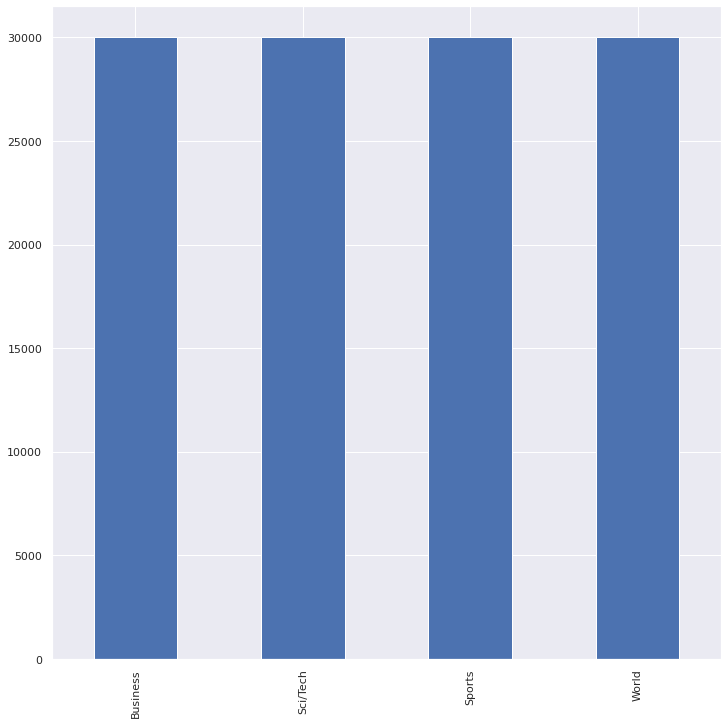

In [11]:
plt.figure(figsize=(12,12))
data['target'].value_counts().plot(kind='bar')

We observe that the label distribution is  balanaced
### Understanding Data

In [12]:
data['input_text'] = (data['Title']+data['Description'])
data.sample(10, random_state=5)

,Class Index,Title,Description,target,input_text
21010,1,UN war crime tribunal calls first witness in M...,The International Criminal Tribunal for Former...,World,UN war crime tribunal calls first witness in M...
41314,2,"MLB, Angelos Talk",MLB officials and Orioles owner Peter Angelos ...,Sports,"MLB, Angelos TalkMLB officials and Orioles own..."
83529,2,Wade Overshadows Shaq As Heat Hit 3-0 (AP),AP - Dwyane Wade had career-highs with 37 poin...,Sports,Wade Overshadows Shaq As Heat Hit 3-0 (AP)AP -...
43249,3,"Oil Clings to \$50, Fuel Stocks to Fall",SINGAPORE (Reuters) - Oil prices hugged \$50 ...,Business,"Oil Clings to \$50, Fuel Stocks to Fall SINGAP..."
35452,4,Cami to get \$100M boost,Cami Automotive in Ingersoll will spend \$100 ...,Sci/Tech,Cami to get \$100M boostCami Automotive in Ing...
2864,3,Intel Says It's Recovered from Missteps,SAN FRANCISCO (Reuters) - Intel Corp. &lt;A H...,Business,Intel Says It's Recovered from Missteps SAN FR...
48425,1,Militant Attacks in India Claim 57 Lives,"GAUHATI, India - Militants bombed utilities, a...",World,Militant Attacks in India Claim 57 LivesGAUHAT...
96692,3,EMI sees music market improving,"EMI, the world #39;s third-largest music group...",Business,"EMI sees music market improvingEMI, the world ..."
37012,1,Syria #39;s role appreciated by Italy,Italy expressed appreciation over Syria #39;s ...,World,Syria #39;s role appreciated by ItalyItaly exp...
104440,3,'Blue Monday' Kicks Off Online Shopping Season...,Reuters - Though U.S. consumers spent the\week...,Business,'Blue Monday' Kicks Off Online Shopping Season...


In [13]:
def WordCloudPlot(data, label):
    """
    to plot wordcloud wrt label in data
    ============================
    data: the dataframe with all fields
    label: genre wrt which we want to plot
    
    return: wordcloud
    """
    sent_list = data[data['target']==label]['input_text']
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    for val in sent_list:
        tokens = val.split()
        comment_words += " ".join(tokens)+" "
        
    wordcloud = WordCloud(width=800, height=800,
                         stopwords = stopwords,
                         min_font_size = 10).generate(comment_words)
    return wordcloud

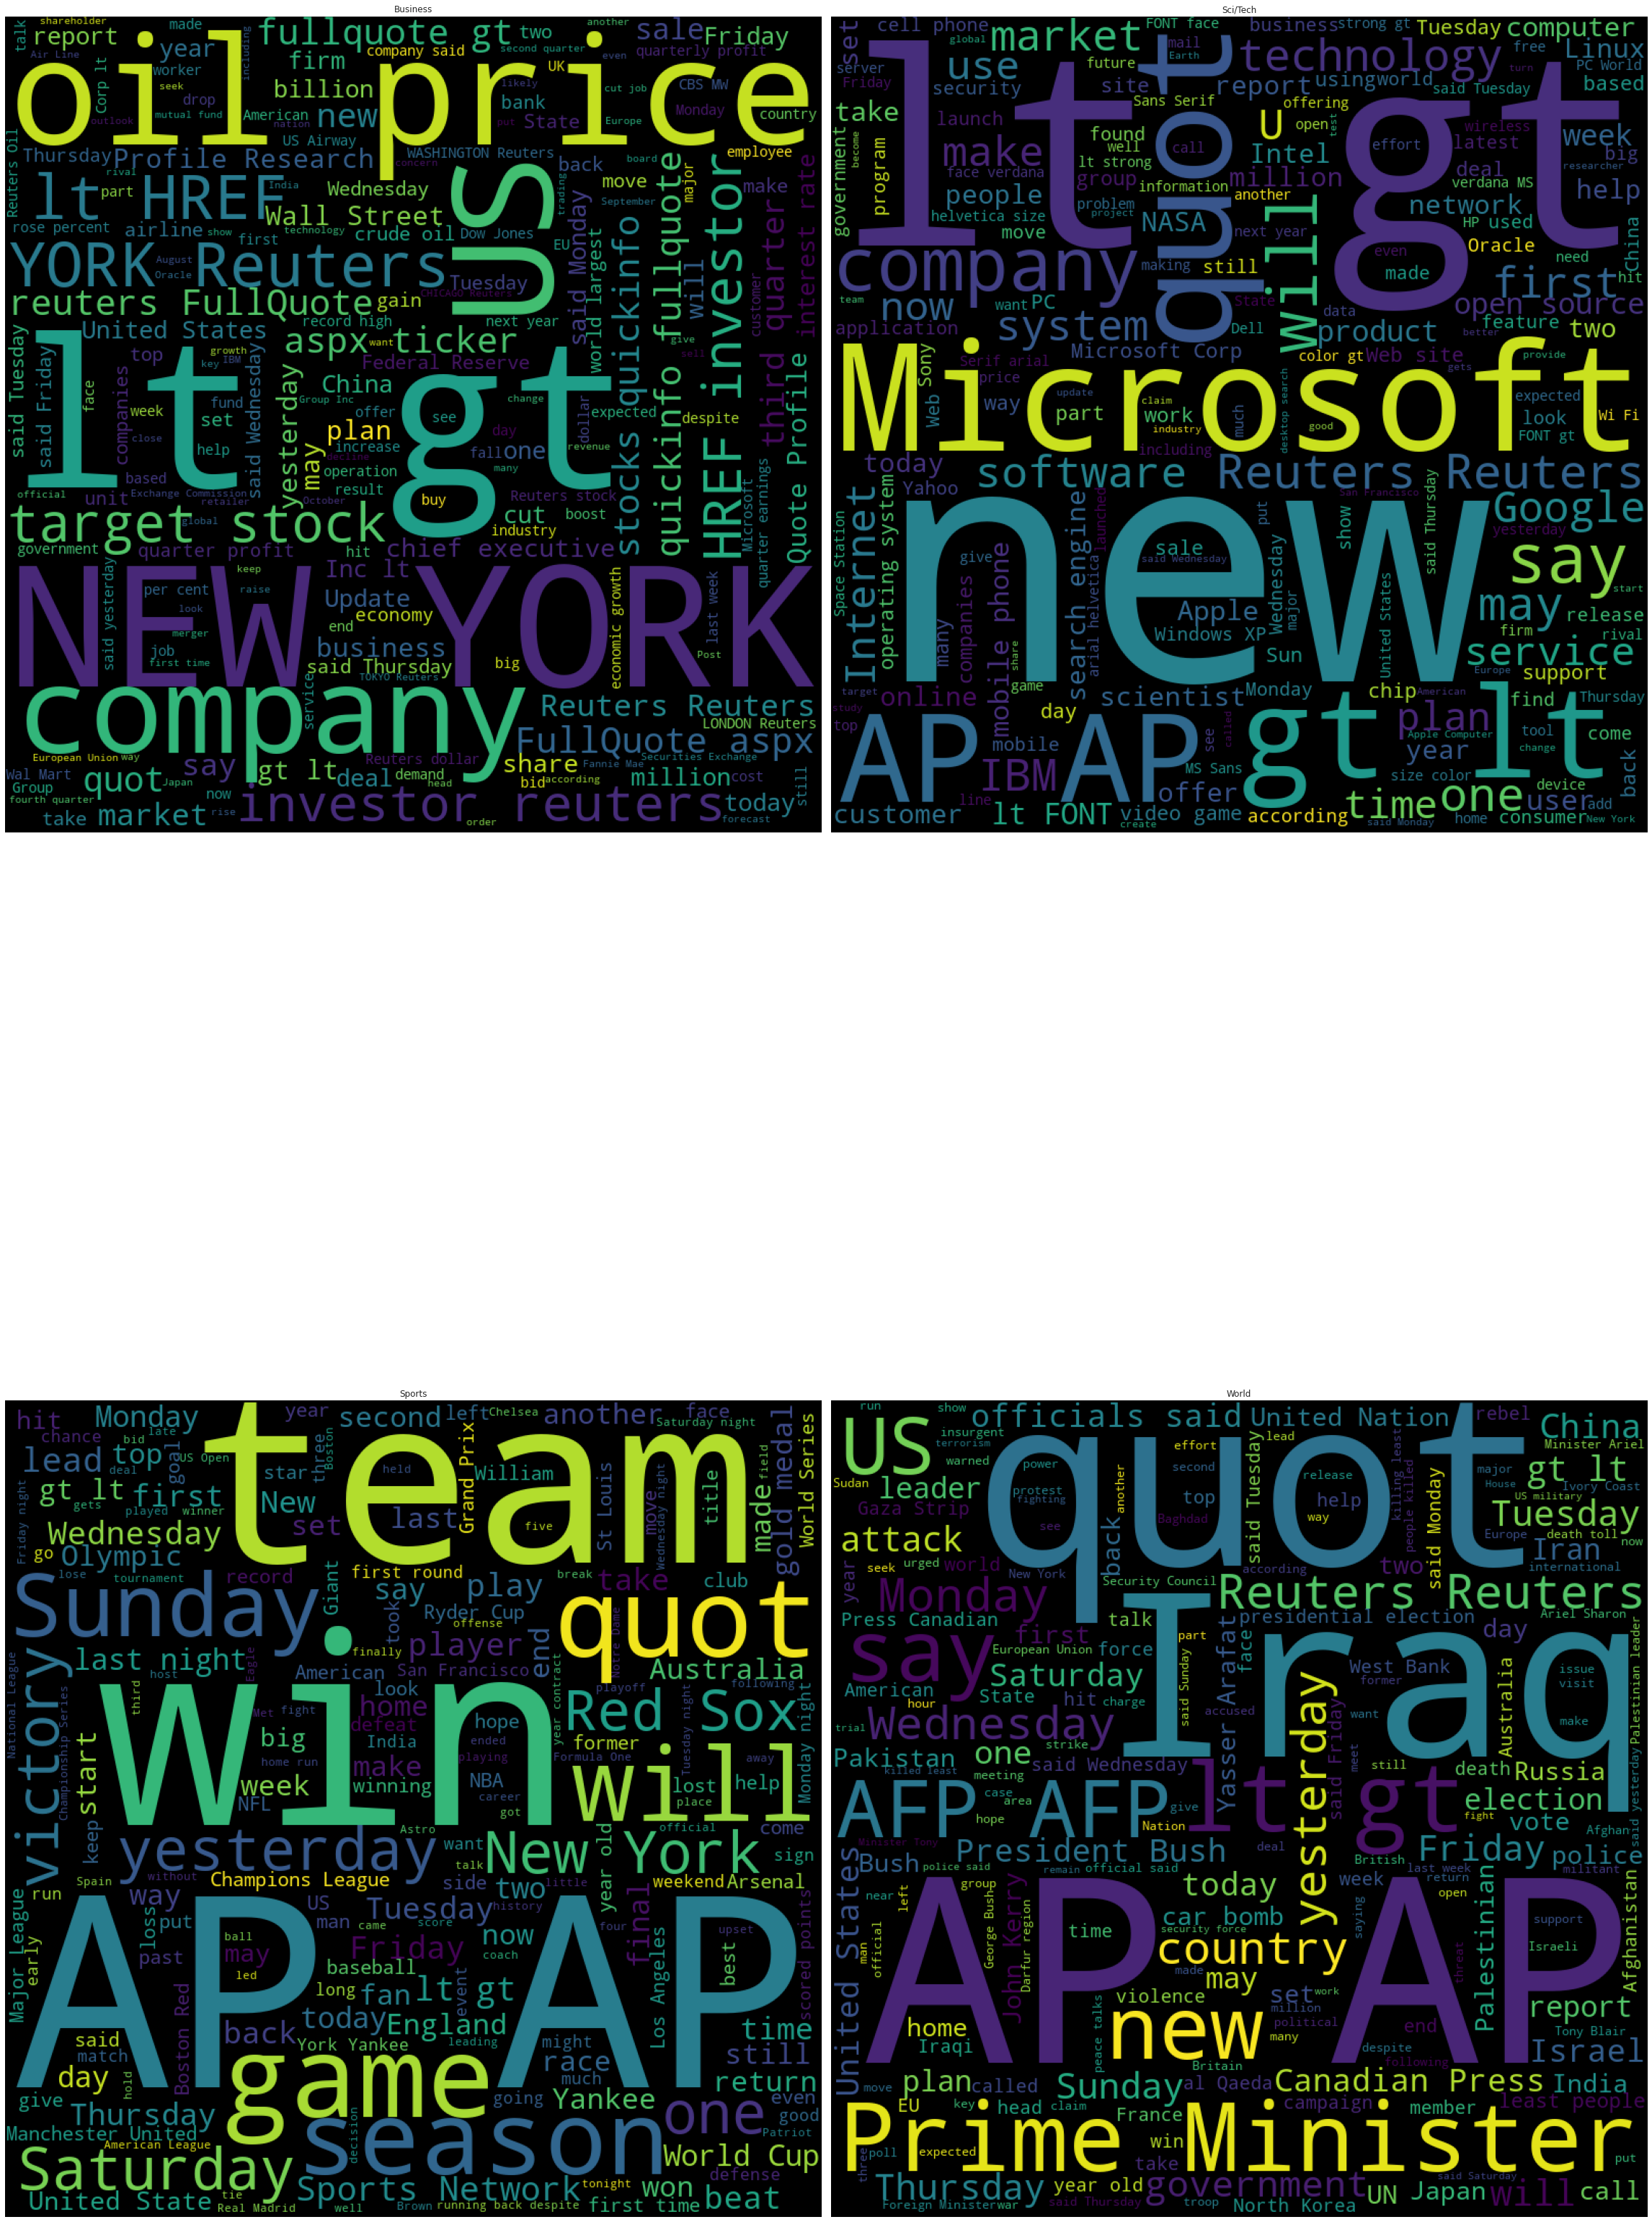

In [14]:
plt.figure(figsize=(32,64))

for i, l in enumerate(list(data['target'].unique())):
    wordcloud = WordCloudPlot(data, l)
    plt.subplot(2,2,i+1)
    plt.title(l)
    plt.axis("off")
    plt.imshow(wordcloud)
plt.tight_layout()
plt.show()

## Preprocessing 
### Data cleaning
First load some rows from description for observation

In [15]:
for val in data['input_text'][:3]:
    print(val)

Wall St. Bears Claw Back Into the Black (Reuters)Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Carlyle Looks Toward Commercial Aerospace (Reuters)Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Oil and Economy Cloud Stocks' Outlook (Reuters)Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.


In [16]:
lematizer = WordNetLemmatizer()

Observed some commas and other grammatical punctuations, as part of preprocessing we can remove that

In [17]:
def preprocess(text):
    '''
    text: raw sentence
       Removing Punctuations
        making lower case 
    Returns : clean text
    '''
    stopwords = set(STOPWORDS)
    clean_text = re.sub(r"\(.+\)", '', text) # removing any thing inside bracket
    cleaned_text = re.sub(r'[^\w\s]', '', text)  # removing anything other than alphabate or numbers
    tokens = word_tokenize(cleaned_text)
    
    token_text = []
    for token in tokens:
      if token not in stopwords:
        token = token.lower()    # change to lower case
        token = lematizer.lemmatize(token)
        token_text.append(token)
    clean_text = " ".join(token_text)
    return clean_text

In [18]:
data['clean_text'] = data['input_text'].apply(lambda x:preprocess(x))

In [19]:
data.sample(10)

,Class Index,Title,Description,target,input_text,clean_text
56832,1,Ljubisa Beara Surrendered to the Serbian Autho...,"Ljubisa Beara, former Chief of Intelligence of...",World,Ljubisa Beara Surrendered to the Serbian Autho...,ljubisa beara surrendered serbian authoritiesl...
34938,3,Spanish bank expanding US presence,A Spanish bank has reached an agreement to acq...,Business,Spanish bank expanding US presenceA Spanish ba...,spanish bank expanding u presencea spanish ban...
67606,4,CA posts Q2 loss on restitution charges,"OCTOBER 21, 2004 (IDG NEWS SERVICE) - Computer...",Sci/Tech,CA posts Q2 loss on restitution chargesOCTOBER...,ca post q2 loss restitution chargesoctober 21 ...
51754,4,Scientist Who Played Role in DNA Discovery Dies,"Nobel laureate Maurice Wilkins, a British scie...",Sci/Tech,Scientist Who Played Role in DNA Discovery Die...,scientist who played role dna discovery diesno...
100682,4,Laser Technique Used to Treat Bad Breath (Reut...,Reuters - If brushing and mouthwash don't impr...,Sci/Tech,Laser Technique Used to Treat Bad Breath (Reut...,laser technique used treat bad breath reutersr...
115937,2,Cleveland signs infielder Hernandez for 1-year,Cleveland Indians: Preparing for their first s...,Sports,Cleveland signs infielder Hernandez for 1-year...,cleveland sign infielder hernandez 1yearclevel...
70220,2,Glazer - has upped his stake. (Getty Images),Manchester United fans have promised Malcolm G...,Sports,Glazer - has upped his stake. (Getty Images)Ma...,glazer upped stake getty imagesmanchester unit...
30895,3,FTC Considers Bounties For Catching Spammers,The federal government is proposing money as a...,Business,FTC Considers Bounties For Catching SpammersTh...,ftc considers bounty for catching spammersthe ...
70048,4,"EBay Merchants Trust Their Eyes, and the Bubbl...",An estimated half-million people make a full- ...,Sci/Tech,"EBay Merchants Trust Their Eyes, and the Bubbl...",ebay merchant trust their eye bubble wrapan es...
4827,1,Stocks to Open Lower on Oil Concerns,NEW YORK - U.S. stocks are seen slightly lower...,World,Stocks to Open Lower on Oil ConcernsNEW YORK -...,stock open lower oil concernsnew york u stock ...


### Reducing Size of Data

In [20]:
bal_data = pd.DataFrame(columns=['Class Index', 'target','clean_text'])

for i in list(data['Class Index'].unique()):
    # if len(data[data['genre']==i]) < 400:
    temp = data[data['Class Index']==i].sample(3000)
    # else:
    #     temp = data[data['genre']==i].sample(400)
    bal_data = bal_data.append(temp)
bal_data['target'].value_counts()

Business    3000
Sci/Tech    3000
Sports      3000
World       3000
Name: target, dtype: int64

In [79]:
bal_data.head()

,Class Index,target,clean_text,Title,Description,input_text
65253,3,Business,social security get 27 percent boostmichael he...,Social Security Gets 2.7 Percent Boost,"Michael Heaton, participates in the Million Wo...",Social Security Gets 2.7 Percent BoostMichael ...
74092,3,Business,business brisk american stream canada flu shot...,Business brisk as Americans stream to Canada f...,Americans are streaming into Canada -- in some...,Business brisk as Americans stream to Canada f...
75750,3,Business,new law could sink check writersatlanta new fe...,New Law Could Sink Check Writers,ATLANTA -- New federal laws take effect Thursd...,New Law Could Sink Check WritersATLANTA -- New...
36292,3,Business,un report foreign direct investment rise leban...,UN report: Foreign direct investment on rise i...,BEIRUT: Foreign direct investment (FDI) in Leb...,UN report: Foreign direct investment on rise i...
17553,3,Business,investor ignore mixed data focus next job repo...,Investors Ignore Mixed Data to Focus on Next J...,Stocks moved higher in a late-session buying s...,Investors Ignore Mixed Data to Focus on Next J...


### Splitting the data
As mentioned in the problem constraint:
* Train to test split ratio must be 60:40

In [22]:
X = bal_data['clean_text']
y = bal_data['target']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=51, stratify=y)

In [24]:
print(f"Shape for train data X: {X_train.shape}")
print(f"Shape for test data X: {X_test.shape}")
print(f"Shape for train data Y: {y_train.shape}")
print(f"Shape for test data Y: {y_test.shape}")

Shape for train data X: (7200,)
Shape for test data X: (4800,)
Shape for train data Y: (7200,)
Shape for test data Y: (4800,)


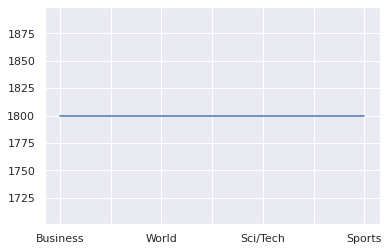

In [25]:
#Class Distribution in train_data
y_train.value_counts().plot()

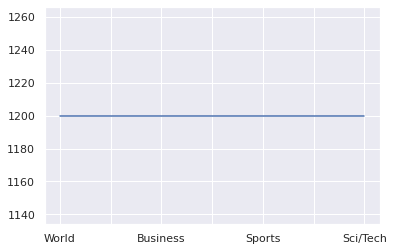

In [26]:
#Class Distribution in test_data
y_test.value_counts().plot()

# Machine Learning Approach
### Performance metric plot preperation

In [27]:
# original fro: https://github.com/prateeknigam9/Hinglish_Classifier/blob/main/CaseStudy_Hinglish.ipynb

def metrics_plot(model,true,to_pred,X_test):
    """
    To plot the metrics and result of performance of model
    =======================================================
    INPUT-
        model: Model Selected
        true: Ground Truth
        to_pred: Values to predict
        X_test: pre-vectorized values
    """
    
    accuracy = model.score(to_pred, true)
    
    f1 = f1_score(true, model.predict(to_pred), average='micro', labels=np.unique(model.predict(to_pred)))
    precision = precision_score(true,model.predict(to_pred),average='micro')
    rec = recall_score(true,model.predict(to_pred),average='micro')
    auc = roc_auc_score(true,model.predict_proba(to_pred),multi_class='ovr')
    
    metrics={}
    metrics['accuracy'] = accuracy
    metrics['F1_score'] = f1
    metrics['precision'] = precision
    metrics['recall'] = rec
    metrics['auc'] = auc
    
    print("="*20,"Model metrics", "="*20)
    print(pd.DataFrame([metrics]))
    
    print("\n")
    print("="*20,"Example output", "="*20)
    pred_top_10 = []
    #temp['News'] =X_test[:10] 
    for i in range(10):
        temp = model.predict(to_pred[i])[0]
        pred_top_10.append(to_label(temp))
        
#     temp = pd.DataFrame(y_pred)
#     temp['Prediction'] = temp[0].apply(lambda x: to_label(x)) 
    print(pd.DataFrame(list(pred_top_10),list(X_test[:10]),columns=['Predicted']))
#    print(temp.head(7))
    print("\n")
    print("="*20,"Confusion Matrix","="*20)
    plt.figure(figsize=(17,17))
    sns.heatmap(confusion_matrix(true,model.predict(to_pred)),annot=True,cmap='Blues', xticklabels=data.target.unique(), yticklabels=data.target.unique())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return metrics

### TF-IDF 

In [28]:
X_train.values[:3]

array(['oil hit 53 winter worry nigeriaoil price scaled new height 53 u crude thursday concern tight winter heating fuel supply unexpected strike nigerian oil terminal',
       'iraqi militant say they shot italianbaghdad iraq iraqi militant said shot killed italian citizen tried break guerrilla roadblock highway outside insurgent stronghold ramadi',
       'report murdoch offer 44 million rockefeller apartment_ rupert murdoch billionaire ceo news corp offered pay 44 million threestory penthouse apartment laurance s rockefeller lived according published report'],
      dtype=object)

In [29]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train.values)

X_train_tfidf = tfidf_vect.transform(X_train.values)
X_test_tfidf = tfidf_vect.transform(X_test.values)


### CountVectorizer 

In [30]:
count_vec = CountVectorizer()
count_vec.fit(X_train.values)

X_train_countvec = count_vec.transform(X_train.values)
X_test_countvec = count_vec.transform(X_test.values)

### MultinomialNB

In [31]:
NB_clf = MultinomialNB()
parameters = {'alpha': np.random.uniform(0.001,10,30)}

randomSearch = RandomizedSearchCV(NB_clf, parameters, cv=5, n_iter=20)
randomSearch.fit(X_train_countvec, y_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=20,
                   param_distributions={'alpha': array([4.47336429, 4.88328526, 3.20069362, 4.28468465, 4.13080798,
       6.52374133, 0.09839904, 2.41238502, 8.45048403, 3.02044837,
       1.81186005, 9.6033964 , 8.22377401, 1.06462565, 9.63449558,
       0.65572315, 9.67250352, 7.22756855, 6.50371686, 3.97555073,
       0.45293729, 5.20883596, 3.9810896 , 0.9232805 , 4.01227196,
       1.5788545 , 3.83815138, 8.64711619, 2.99538191, 3.50952993])})

In [32]:
NB_clf = MultinomialNB(**randomSearch.best_params_)
NB_clf.fit(X_train_countvec,y_train)

MultinomialNB(alpha=0.923280497079046)

==================== Model metrics ====================
   accuracy  F1_score  precision    recall       auc
0  0.892083  0.892083   0.892083  0.892083  0.975163


==================== Example output ====================
                                                   Predicted
italy celebrates hostage returntwo italian aid ...  Sci/Tech
huttner departs virginair new zealand will incr...  Sci/Tech
sprint deal raise sponsorship questionswireless...  Sci/Tech
freddie mac may face sec civil action los angel...  Sci/Tech
bell set test debutian bell almost certain make...  Sci/Tech
australia press murdoch drum up support for u m...  Sci/Tech
after arafat peace chanceit uncertain history u...  Sci/Tech
hollinger panel say it owner took cash new york...  Sci/Tech
boeheim waiting let edelin practicesyracuse ny ...  Sci/Tech
doctor visit arafat a his health worsenspalesti...  Sci/Tech


==================== Confusion Matrix ====================


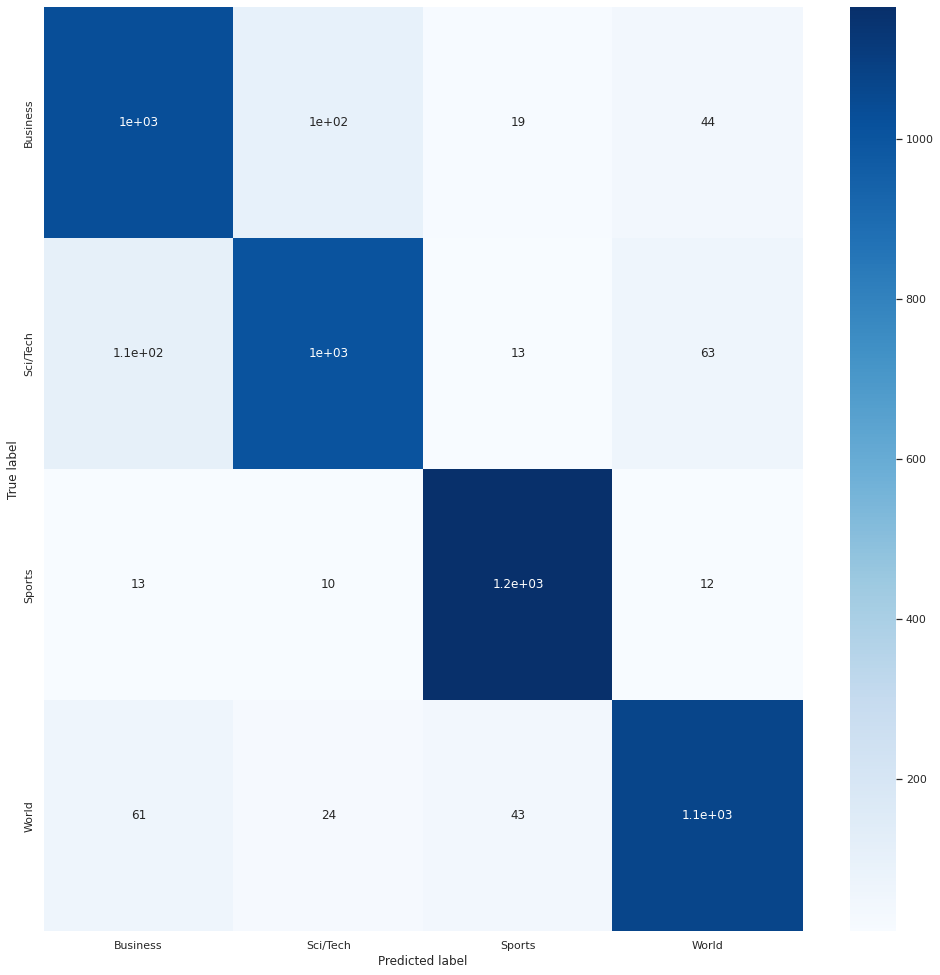

In [33]:
NB_CLF_METRICS = metrics_plot(model = NB_clf,true = y_test,to_pred = X_test_countvec,X_test = X_test)

### Random Forest 

In [34]:
model_params = {
    'n_estimators': randint(10,200),
    'max_depth': range(8,32),
    'criterion': ['gini', 'entropy']
}

rf_model = RandomForestClassifier()
rfCV_model = RandomizedSearchCV(rf_model, model_params, n_iter=10, cv=2, random_state=1)
rfCV_model = rfCV_model.fit(X_train_tfidf, y_train)

print(rfCV_model.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 28, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 149, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [35]:
n_estimators = rfCV_model.best_estimator_.get_params()['n_estimators']
max_features = rfCV_model.best_estimator_.get_params()['max_features']
min_samples_split = rfCV_model.best_estimator_.get_params()['min_samples_split']

In [36]:
RF_clf = RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split)
RF_clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(n_estimators=149)

==================== Model metrics ====================
   accuracy  F1_score  precision   recall       auc
0   0.85375   0.85375    0.85375  0.85375  0.964358


==================== Example output ====================
                                                   Predicted
italy celebrates hostage returntwo italian aid ...  Sci/Tech
huttner departs virginair new zealand will incr...  Sci/Tech
sprint deal raise sponsorship questionswireless...  Sci/Tech
freddie mac may face sec civil action los angel...  Sci/Tech
bell set test debutian bell almost certain make...  Sci/Tech
australia press murdoch drum up support for u m...  Sci/Tech
after arafat peace chanceit uncertain history u...  Sci/Tech
hollinger panel say it owner took cash new york...  Sci/Tech
boeheim waiting let edelin practicesyracuse ny ...  Sci/Tech
doctor visit arafat a his health worsenspalesti...  Sci/Tech


==================== Confusion Matrix ====================


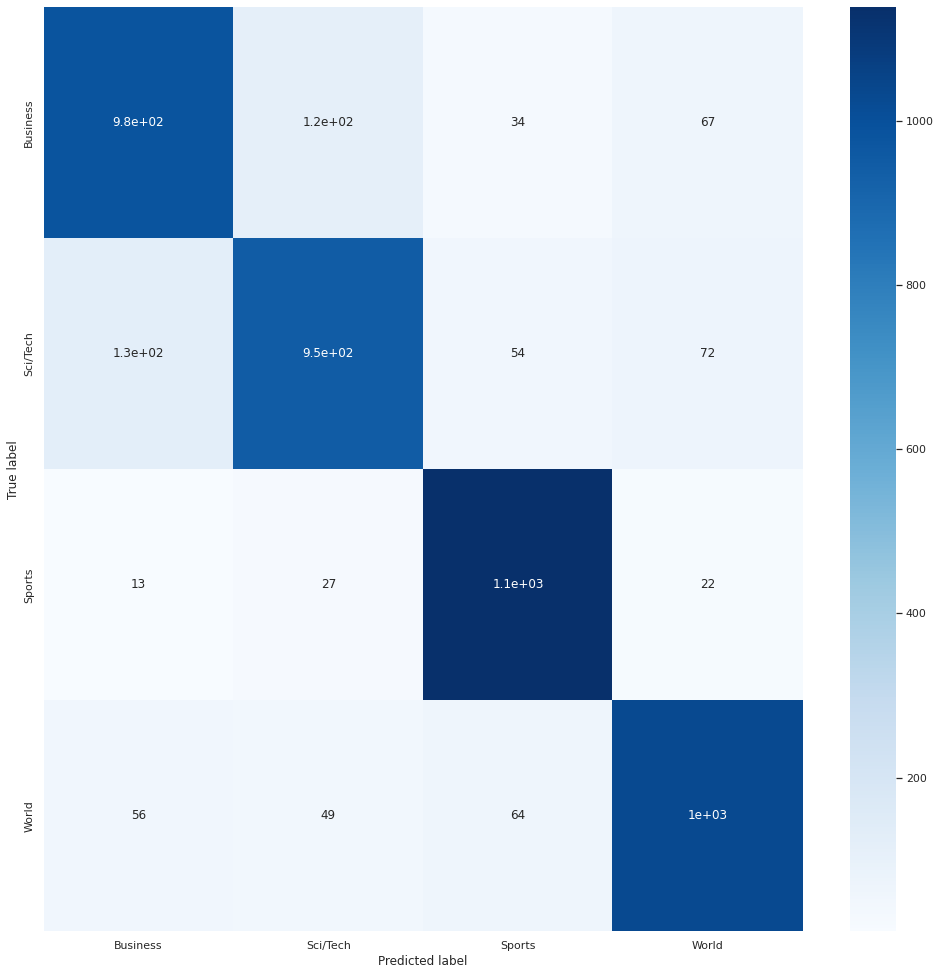

In [37]:
RF_CLF_METRICS = metrics_plot(model = RF_clf,true = y_test,to_pred = X_test_tfidf,X_test = X_test)

### Logistic Regression 

In [38]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [82]:
LR_clf = LogisticRegression()
params  = {'C' : np.logspace(0, 4, 20)}

randomSearch = RandomizedSearchCV(LR_clf,params,cv=2,n_iter=100)
randomSearch.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=2, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': array([1.00000000e+00, 1.62377674e+00, 2.63665090e+00, 4.28133240e+00,
       6.95192796e+00, 1.12883789e+01, 1.83298071e+01, 2.97635144e+01,
       4.83293024e+01, 7.84759970e+01, 1.27427499e+02, 2.06913808e+02,
       3.35981829e+02, 5.45559478e+02, 8.85866790e+02, 1.43844989e+03,
       2.33572147e+03, 3.79269019e+03, 6.15848211e+03, 1.00000000e+04])})

In [83]:
LR_clf = LogisticRegression(**randomSearch.best_params_)
LR_clf.fit(X_train_tfidf,y_train)

LogisticRegression(C=2.636650898730358)

==================== Model metrics ====================
   accuracy  F1_score  precision    recall       auc
0  0.893125  0.893125   0.893125  0.893125  0.975574


==================== Example output ====================
                                                   Predicted
italy celebrates hostage returntwo italian aid ...  Sci/Tech
huttner departs virginair new zealand will incr...  Sci/Tech
sprint deal raise sponsorship questionswireless...  Sci/Tech
freddie mac may face sec civil action los angel...  Sci/Tech
bell set test debutian bell almost certain make...  Sci/Tech
australia press murdoch drum up support for u m...  Sci/Tech
after arafat peace chanceit uncertain history u...  Sci/Tech
hollinger panel say it owner took cash new york...  Sci/Tech
boeheim waiting let edelin practicesyracuse ny ...  Sci/Tech
doctor visit arafat a his health worsenspalesti...  Sci/Tech


==================== Confusion Matrix ====================


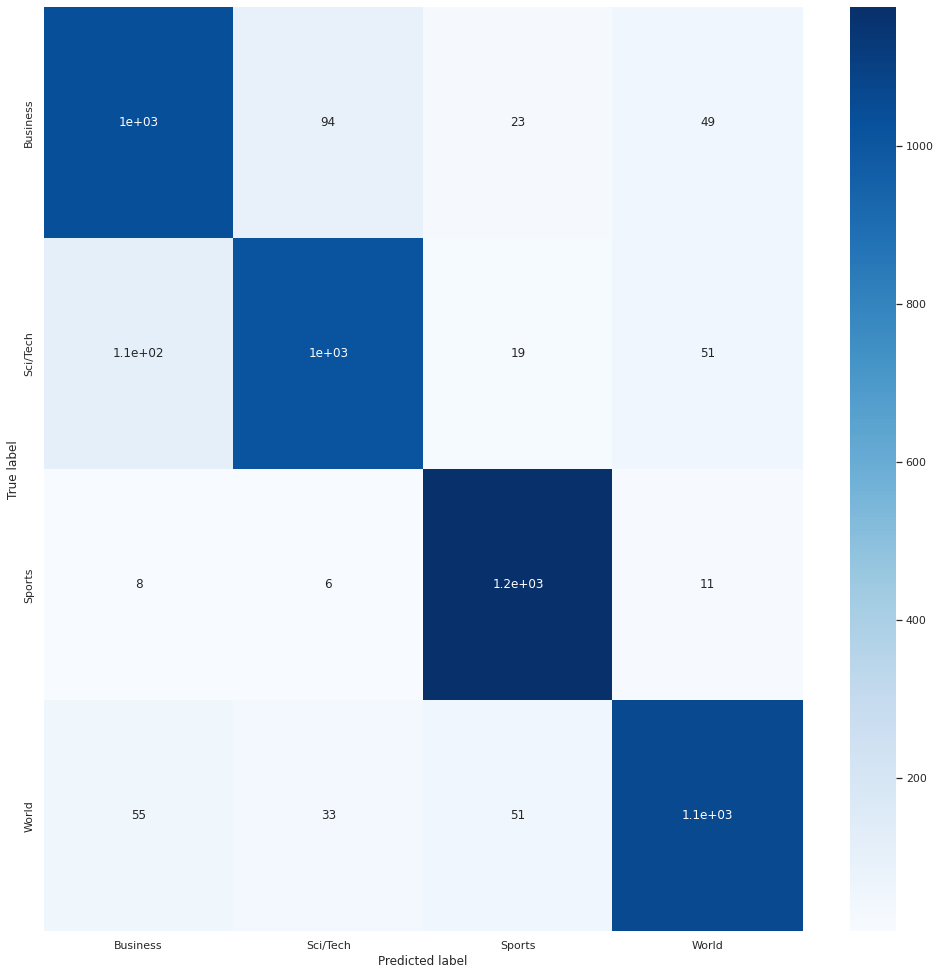

In [41]:
LR_CLF_METRICS = metrics_plot(model = LR_clf,true = y_test,to_pred = X_test_tfidf,X_test = X_test)

In [42]:
ML_Comparison = pd.DataFrame([LR_CLF_METRICS,RF_CLF_METRICS,NB_CLF_METRICS],
                             index = ['Logistic Regression',
                                      'Random Forest',
                                      'Naive Bayes'])
ML_Comparison 

,accuracy,F1_score,precision,recall,auc
Logistic Regression,0.893125,0.893125,0.893125,0.893125,0.975574
Random Forest,0.853750,0.853750,0.853750,0.853750,0.964358
Naive Bayes,0.892083,0.892083,0.892083,0.892083,0.975163


# Deep Learning Models

In [43]:
import tensorflow as tf
import keras
from keras.layers import Dense,Input,Embedding,LSTM,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras import Model
from keras.initializers import Constant

### Deep learning performance metrics

In [44]:
def DL_metrics_plot(model, to_pred, true, unencoded_true_X, unencoded_true_y):
    """
    To plot the metrics and result of performance of Deep learning model
    =======================================================
    INPUT-
        model: DL Model Selected
        true: encoded Ground Truth
        to_pred: test data after preprocessing
        X_test: pre-vectorized values
        unencoded_true_X : test sentences
        unencoded_true_y : Ground truth values
    """
    _, accuracy, f1_score, precision, recall = model.evaluate(to_pred, true)

    DL_metric={}
    DL_metric['accuracy'] = accuracy
    DL_metric['F1_score'] = f1_score
    DL_metric['precision'] = precision
    DL_metric['recall'] = recall

    print("="*20,"Model metrics","="*20)
    print(pd.DataFrame([DL_metric]))

    try:
        outputs=[]
        for i in range(10):
            pred = model.predict(to_pred[i].reshape(1,-1))
            output = encoder.inverse_transform([np.argmax(pred[0])])[0]
            outputs.append(output)
        sent_to_classify = list(unencoded_true_X)[:10]
        print("\n")
        print("="*20,"Example output","="*20)
        print(pd.DataFrame(outputs,sent_to_classify,columns=['Predicted']))

        print("\n")
        print("="*20,"Confusion Matrix","="*20)
        predicted=[]
        for i in range(true.shape[0]):
            pred = model.predict(to_pred[i].reshape(1,-1))
            output = encoder.inverse_transform([np.argmax(pred[0])])[0]
            predicted.append(output)
            
        plt.figure(figsize=(17,17))
        sns.heatmap(confusion_matrix(unencoded_true_y,predicted),annot=True,cmap='Blues')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
    except:
      pass
    return DL_metric

In [45]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Simple Artificial Neural Network
* bag of words with keras

### Preprocessing

In [46]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [47]:
num_classes = np.max(y_train_encoded) + 1
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

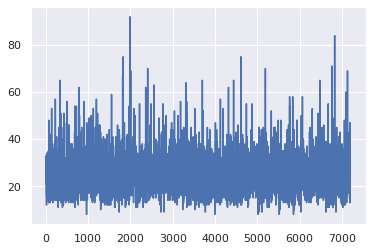

In [48]:
length_of_sent = []
for sent in np.array(X_train):
    length_of_sent.append(len(sent.split()))
plt.plot(length_of_sent)

In [49]:
max_len = np.mean(length_of_sent)
max_len = int(max_len)+3

In [50]:
tknzr = Tokenizer()
tknzr.fit_on_texts(X_train)

In [51]:
train_matrix = tknzr.texts_to_matrix(X_train)
test_matrix = tknzr.texts_to_matrix(X_test)

In [52]:
y_train_encoded

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

### Model Preparation and training

In [53]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(train_matrix[0].shape))
layer = Dense(512,activation='relu')(input_layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(64,activation='relu')(layer)
layer = Dropout(0.5)(layer)
output_layer = Dense(4,activation='softmax')(layer)

ANNmodel = Model(inputs=input_layer,outputs=output_layer)

ANNmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [54]:
ANNmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27486)]           0         
                                                                 
 dense (Dense)               (None, 512)               14073344  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260   

In [55]:
ANNmodel.fit(train_matrix,y_train_encoded,validation_split=0.1,batch_size=512,epochs=20)

Epoch 1/20
13/13 [==============================] - 3s 91ms/step - loss: 1.2980 - accuracy: 0.4566 - f1_m: 0.0303 - precision_m: 0.3846 - recall_m: 0.0162 - val_loss: 1.0022 - val_accuracy: 0.8000 - val_f1_m: 0.2933 - val_precision_m: 0.9881 - val_recall_m: 0.1728
Epoch 2/20
13/13 [==============================] - 1s 49ms/step - loss: 0.7152 - accuracy: 0.7974 - f1_m: 0.6531 - precision_m: 0.9362 - recall_m: 0.5287 - val_loss: 0.3661 - val_accuracy: 0.9000 - val_f1_m: 0.8976 - val_precision_m: 0.9335 - val_recall_m: 0.8643
Epoch 3/20
13/13 [==============================] - 1s 49ms/step - loss: 0.2734 - accuracy: 0.9270 - f1_m: 0.9199 - precision_m: 0.9437 - recall_m: 0.8977 - val_loss: 0.3266 - val_accuracy: 0.9000 - val_f1_m: 0.9054 - val_precision_m: 0.9157 - val_recall_m: 0.8953
Epoch 4/20
13/13 [==============================] - 1s 49ms/step - loss: 0.1064 - accuracy: 0.9736 - f1_m: 0.9722 - precision_m: 0.9761 - recall_m: 0.9683 - val_loss: 0.3688 - val_accuracy: 0.8972 - val_f1

In [56]:
ANN_MODEL_METRIC = DL_metrics_plot(model = ANNmodel,to_pred=test_matrix,true=y_test_encoded,unencoded_true_X=X_test, unencoded_true_y=y_train)

150/150 [==============================] - 1s 6ms/step - loss: 0.8526 - accuracy: 0.8819 - f1_m: 0.8824 - precision_m: 0.8838 - recall_m: 0.8810
==================== Model metrics ====================
   accuracy  F1_score  precision    recall
0  0.881875    0.8824    0.88381  0.881042


==================== Example output ====================
                                                   Predicted
italy celebrates hostage returntwo italian aid ...     World
huttner departs virginair new zealand will incr...  Business
sprint deal raise sponsorship questionswireless...  Business
freddie mac may face sec civil action los angel...  Business
bell set test debutian bell almost certain make...    Sports
australia press murdoch drum up support for u m...  Business
after arafat peace chanceit uncertain history u...     World
hollinger panel say it owner took cash new york...  Business
boeheim waiting let edelin practicesyracuse ny ...    Sports
doctor visit arafat a his health worsenspale

<Figure size 1224x1224 with 0 Axes>

### Classification with LSTM

In [57]:
vocabulary = tknzr.word_index

In [58]:
print(f' The word token dictionary : \n {dict(list(tknzr.word_index.items())[0: 10])}')

 The word token dictionary : 
 {'39s': 1, 'said': 2, 'new': 3, 'u': 4, 'the': 5, 'will': 6, 'year': 7, 'company': 8, 'first': 9, 'reuters': 10}


In [59]:
train_seq = tknzr.texts_to_sequences(X_train)
test_seq = tknzr.texts_to_sequences(X_test)

In [60]:
train_padded = pad_sequences(train_seq,maxlen = max_len,padding='post')
test_padded = pad_sequences(test_seq,maxlen=max_len,padding='post')

In [61]:
print(f'Train data shape after padding: {train_padded.shape}')
print(f'Test data shape after padding: {test_padded.shape}')
print(f'Examples of paadding : \n {train_padded[34]},\n {train_padded[24]}, \n {train_padded[15]}')

Train data shape after padding: (7200, 28)
Test data shape after padding: (4800, 28)
Examples of paadding : 
 [ 8182  3496  1383  1384  8183   894 11744    11  3860   269    88   600
     5  8184   168   394    42   319 11745  6566 11746  3861   101  6567
  1489   320   266  1026],
 [   33  2944  2752  3489 11723   681  1487  3489  1086  1222  2752  1223
    57     2  3490 11724   293  2752  1223    57     0     0     0     0
     0     0     0     0], 
 [ 2940  2564  2160  5558 11706  1753   186  5558   792  1175  2161  1485
   436  1379  2940  3188   292  4805   486  8156  1128  4806    32  1676
   162     0     0     0]


In [62]:
train_padded.shape

(7200, 28)

### Word2vec

In [63]:
sentences =  []
for text in data['clean_text']:
  sentences.append(word_tokenize(text))

In [64]:
print("Length of Sentences we got: ", len(sentences))

Length of Sentences we got:  120000


In [65]:
w2v_model=gensim.models.Word2Vec(sentences=sentences,size=512,window=10,min_count=5)

In [66]:
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(28368031, 30827450)

In [67]:
# top similar world to good
w2v_model.wv.most_similar('win')

[('victory', 0.703426718711853),
 ('triumph', 0.5938881635665894),
 ('winning', 0.5881723761558533),
 ('defeat', 0.5737251043319702),
 ('beat', 0.5685908794403076),
 ('defeated', 0.5657876133918762),
 ('beating', 0.5142750144004822),
 ('earn', 0.498138964176178),
 ('clinch', 0.4976285994052887),
 ('rout', 0.4880080819129944)]

In [68]:
# total numberof extracted words.
vocab=w2v_model.wv.vocab
print(f'number of words are: {len(vocab)}')

number of words are: 27773


Now creating a dictionary with words in vocab and their embeddings. This will be used when we will be creating embedding matrix (for feeding to keras embedding layer).

In [69]:
vocab_key=list(vocab.keys())
word_vec_dict={}
for word in vocab_key:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  27773


In [70]:
max_text_len = max_len #max length
vocab_size = len(tknzr.word_index)+1 # total number of words
embed_dim = 512 # embedding dimension as choosen in word2vec constructor

In [71]:
# now creating the embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tknzr.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

Building LSTM model

In [72]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(train_padded.shape[1],),name='INPUT')
layer = Embedding(input_dim=vocab_size,output_dim=embed_dim,embeddings_initializer=Constant(embed_matrix),name='EMBEDDING')(input_layer)
layer = LSTM(units=100,activation='relu',dropout=0.2, recurrent_dropout=0.2,name='LSTM')(layer)
layer = Dense(128,activation='relu',name='DENSE1')(layer)
output_layer =  Dense(4,activation='softmax',name='OUTPUT')(layer)

LSTMmodel = Model(inputs=input_layer,outputs = output_layer)

LSTMmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [73]:
LSTMmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 28)]              0         
                                                                 
 EMBEDDING (Embedding)       (None, 28, 512)           14072832  
                                                                 
 LSTM (LSTM)                 (None, 100)               245200    
                                                                 
 DENSE1 (Dense)              (None, 128)               12928     
                                                                 
 OUTPUT (Dense)              (None, 4)                 516       
                                                                 
Total params: 14,331,476
Trainable params: 14,331,476
Non-trainable params: 0
_________________________________________________________________


In [74]:
LSTMmodel.fit(train_padded,y_train_encoded,validation_split=0.2,batch_size=512,epochs=30)

Epoch 1/30
12/12 [==============================] - 5s 181ms/step - loss: 1.0334 - accuracy: 0.6387 - f1_m: 0.4557 - precision_m: 0.7826 - recall_m: 0.3630 - val_loss: 0.6848 - val_accuracy: 0.8083 - val_f1_m: 0.7617 - val_precision_m: 0.8823 - val_recall_m: 0.6706
Epoch 2/30
12/12 [==============================] - 2s 147ms/step - loss: 0.5881 - accuracy: 0.8172 - f1_m: 0.7892 - precision_m: 0.8780 - recall_m: 0.7178 - val_loss: 0.4817 - val_accuracy: 0.8486 - val_f1_m: 0.8281 - val_precision_m: 0.8928 - val_recall_m: 0.7722
Epoch 3/30
12/12 [==============================] - 2s 139ms/step - loss: 0.4277 - accuracy: 0.8592 - f1_m: 0.8503 - precision_m: 0.9079 - recall_m: 0.7998 - val_loss: 0.3911 - val_accuracy: 0.8729 - val_f1_m: 0.8651 - val_precision_m: 0.9020 - val_recall_m: 0.8310
Epoch 4/30
12/12 [==============================] - 2s 143ms/step - loss: 0.3468 - accuracy: 0.8797 - f1_m: 0.8770 - precision_m: 0.9072 - recall_m: 0.8488 - val_loss: 0.3557 - val_accuracy: 0.8868 - va

150/150 [==============================] - 2s 11ms/step - loss: 0.9420 - accuracy: 0.8860 - f1_m: 0.8864 - precision_m: 0.8876 - recall_m: 0.8852
==================== Model metrics ====================
   accuracy  F1_score  precision    recall
0  0.886042  0.886392    0.88762  0.885208


==================== Example output ====================
                                                   Predicted
italy celebrates hostage returntwo italian aid ...     World
huttner departs virginair new zealand will incr...  Business
sprint deal raise sponsorship questionswireless...  Business
freddie mac may face sec civil action los angel...  Business
bell set test debutian bell almost certain make...    Sports
australia press murdoch drum up support for u m...  Business
after arafat peace chanceit uncertain history u...     World
hollinger panel say it owner took cash new york...  Business
boeheim waiting let edelin practicesyracuse ny ...    Sports
doctor visit arafat a his health worsenspal

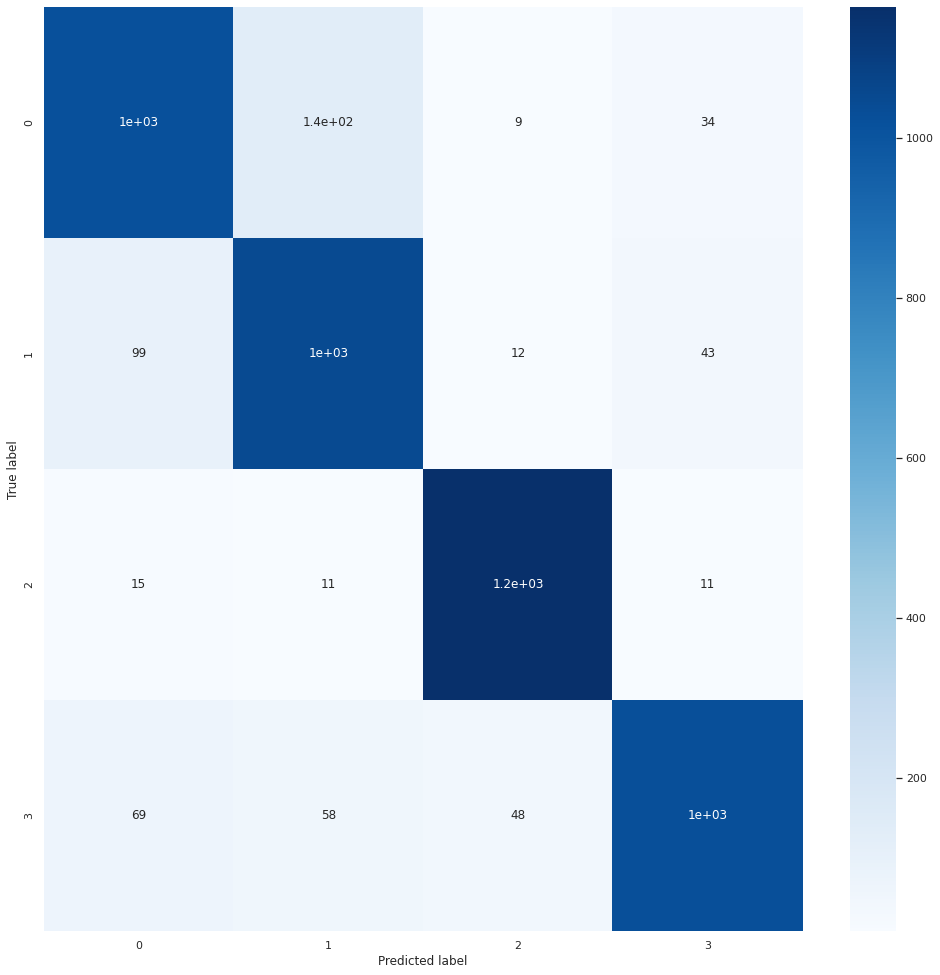

In [75]:
LSTM_MODEL_METRIC = DL_metrics_plot(model = LSTMmodel,to_pred=test_padded,true=y_test_encoded,unencoded_true_X=X_test,unencoded_true_y = y_test)

In [76]:
DL_Comparison = pd.DataFrame([ANN_MODEL_METRIC,LSTM_MODEL_METRIC],
                             index = ['BOW with Keras',
                                      'LSTM'])
DL_Comparison

,accuracy,F1_score,precision,recall
BOW with Keras,0.881875,0.882400,0.88381,0.881042
LSTM,0.886042,0.886392,0.88762,0.885208


In [77]:
list_of_metrices = ['accuracy','F1_score','precision','recall']
ML_Comparison = ML_Comparison[list_of_metrices]
DL_Comparison = DL_Comparison[list_of_metrices]

In [78]:
FINAL_METRIC = pd.concat([ML_Comparison,DL_Comparison])
FINAL_METRIC.sort_values(by='F1_score',ascending=False,inplace=True)
FINAL_METRIC

,accuracy,F1_score,precision,recall
Logistic Regression,0.893125,0.893125,0.893125,0.893125
Naive Bayes,0.892083,0.892083,0.892083,0.892083
LSTM,0.886042,0.886392,0.887620,0.885208
BOW with Keras,0.881875,0.882400,0.883810,0.881042
Random Forest,0.853750,0.853750,0.853750,0.853750


# References
* Dataset from [kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/code?select=train.csv)
* **METRIC_PLOT** idea from [github.com/prateeknigam9/Hinglish_Classifier](https://github.com/prateeknigam9/Hinglish_Classifier/blob/main/CaseStudy_Hinglish.ipynb)
* Youtube chanels I refered for this project:
 * [Krish Naik](https://www.youtube.com/user/krishnaik06)
 * [Unfold Data Science](https://www.youtube.com/watch?v=2Vs7dRUr4a4)
* [towardsdatascience.com/word-embeddings-and-document-vectors-when-in-doubt-simplify](https://towardsdatascience.com/word-embeddings-and-document-vectors-when-in-doubt-simplify-8c9aaeec244e)
* [wiki.pathmind.com/word2vec](https://wiki.pathmind.com/word2vec)